# Imports

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import math
import time

# Function Definitions

## Rotation Matrices

In [2]:
def xRot(theta):
    # Rotation matrix for the x axis
    angle = math.radians(theta)
    mat = np.array([[1, 0, 0],
                   [0, math.cos(angle), math.sin(angle)],
                   [0, -math.sin(angle), math.cos(angle)]])
    return mat

In [3]:
def yRot(theta):
    # Rotation matrix for the y axis
    angle = math.radians(theta)
    mat = np.array([[math.cos(angle), 0, math.sin(angle)],
                   [0, 1, 0],
                   [-math.sin(angle), 0, math.cos(angle)]])
    return mat

In [4]:
def zRot(theta):
    # Rotation matrix for the z axis
    angle = math.radians(theta)
    mat = np.array([[math.cos(angle), math.sin(angle), 0],
                   [-math.sin(angle), math.cos(angle), 0],
                   [0, 0, 1]])
    return mat

## Body Functions

In [5]:
def bodyPos(pitch = 0, roll = 0, yaw = 0, Tx = 0, Ty = 0, Tz = 0):
    # Applies rotations in pitch, roll, and yaw and translations in x, y, and z tot he body.
    body_rot = np.matmul(zRot(yaw), yRot(roll))
    body_rot = np.matmul(body_rot, xRot(pitch));
    
    body_0 = np.matmul(inv(body_rot), np.array([[body_offset / 2, body_offset * math.sin(math.pi / 3), 0]]).T);
    body_1 = np.matmul(inv(body_rot), np.array([[body_offset, 0, 0]]).T);
    body_2 = np.matmul(inv(body_rot), np.array([[body_offset / 2, -body_offset * math.sin(math.pi / 3), 0]]).T);
    body_3 = np.matmul(inv(body_rot), np.array([[-body_offset / 2, -body_offset * math.sin(math.pi / 3), 0]]).T);
    body_4 = np.matmul(inv(body_rot), np.array([[-body_offset, 0, 0]]).T);
    body_5 = np.matmul(inv(body_rot), np.array([[-body_offset / 2, body_offset * math.sin(math.pi / 3), 0]]).T);
    
    body_model = np.concatenate((body_0.T, body_1.T, body_2.T, body_3.T, body_4.T, body_5.T, body_0.T), axis = 0)
    translation = [[Tx, Ty, Tz],
    [Tx, Ty, Tz],
    [Tx, Ty, Tz],
    [Tx, Ty, Tz],
    [Tx, Ty, Tz],
    [Tx, Ty, Tz],
    [Tx, Ty, Tz]]
    
    body_model = body_model + translation
    
    return body_model

## Leg Functions

In [6]:
def legPos(coax_angle, femur_angle, tibia_angle, body_model, leg_num):
    # finds the positions for the coax, femur, and tibia leg segments and adds them to the body model
    coax_rot = zRot(coax_angle)
    femur_rot = np.matmul(yRot(femur_angle), coax_rot)
    tibia_rot = np.matmul(yRot(tibia_angle), femur_rot)
    
    leg_coax = np.matmul(inv(coax_rot), np.array([[coax, 0, 0]]).T) + np.array([body_model[leg_num, :]]).T
    leg_femur = np.matmul(inv(femur_rot), np.array([[femur, 0, 0]]).T) + leg_coax
    leg_tibia = np.matmul(inv(tibia_rot), np.array([[0, 0, -tibia]]).T) + leg_femur
                       
    leg_positions = np.concatenate((np.array([body_model[leg_num, :]]), leg_coax.T, leg_femur.T, leg_tibia.T), axis = 0)
    return leg_positions

In [7]:
def legAngle(x, y, z):
    # finds the angles for the coax, femur, and tibia leg segments
    coax_angle = math.degrees(math.atan2(y, x));
    coax_rot = zRot(-coax_angle)
    leg_rotated = np.matmul(inv(coax_rot), np.array([[x, y, z]]).T)
    femur_angle = math.degrees(math.acos((tibia ** 2 - femur ** 2 - leg_rotated[2] ** 2 - (leg_rotated[0] - coax) ** 2) / (-2 * femur * (math.sqrt(leg_rotated[2] ** 2 + (leg_rotated[0] - coax) ** 2))))) - math.degrees(math.atan2(-leg_rotated[2], (leg_rotated[0] - coax)));
    tibia_angle = math.degrees(math.acos((leg_rotated[2] ** 2 + (leg_rotated[0] - coax) ** 2 - femur ** 2 - tibia ** 2) / (-2 * femur * tibia))) - 90;
    
    if abs(coax_angle) <= 1e-10:
        coax_angle = 0;
        
    if abs(femur_angle) <= 1e-10:
        femur_angle = 0;
    
    if abs(tibia_angle) <= 1e-10:
        tibia_angle = 0;
    
    return [coax_angle, femur_angle, tibia_angle]

### Create the starting angles of the legs on the hexapod based 

In [8]:
def startLegPos(body_model, start_radius = 150, start_height = 20):
    start_leg_pos = np.array([[start_radius * math.cos(math.pi / 3), start_radius * math.sin(math.pi / 3), - start_height],
    [start_radius, 0, - start_height],
    [start_radius * math.cos(- math.pi / 3), start_radius * math.sin(- math.pi / 3), - start_height],
    [start_radius * math.cos(- 2 * math.pi / 3) , start_radius * math.sin(- 2 * math.pi / 3), - start_height],
    [- start_radius, 0, - start_height],
    [start_radius * math.cos(2 * math.pi / 3), start_radius * math.sin(2 * math.pi / 3), - start_height]])
    start_leg =  recalculateLegAngles(start_leg_pos, body_model)
    return start_leg

### Get the current feet positions

In [9]:
def getFeetPos(leg_model):
    feet_positions = np.empty([6, 3])
    for i in range(6):
        feet_positions[i, :] = leg_model[3, :, i]
    return feet_positions

### General Foot Position to Leg Angle Function

In [10]:
def recalculateLegAngles(feet_positions, body_model):
    leg_angles = np.empty([6, 3])
    for i in range(6):
        leg_angles[i, :] = legAngle(feet_positions[i, 0] - body_model[i, 0], feet_positions[i, 1] - body_model[i, 1], feet_positions[i, 2] - body_model[i, 2])
    return leg_angles

### Apply Leg Angles to Model

In [11]:
def legModel(leg_angles):
    leg_model = np.empty([4, 3, 6])
    for i in range(6):
        leg_model[:, :, i] = legPos(leg_angles[i][0], leg_angles[i][1], leg_angles[i][2], body_model, i) #coax angle, femur angle, tibia angle, model of the hexapod body, leg number
    return leg_model

## Walking Functions

### Step Calculation

In [12]:
def step(step_angle = 90, distance = 30, step_height = 15, right_foot = True):
    z_resolution = 1 # the forward distance of each sub step.
    x_resolution = z_resolution * math.cos(math.radians(step_angle))
    y_resolution = z_resolution * math.sin(math.radians(step_angle))

    z = np.array([-(i ** 2) / 4 + ((step_height) ** 2) / 4 for i in np.arange (- step_height, step_height + z_resolution, z_resolution)])
    x = np.linspace(0, distance * math.cos(math.radians(step_angle)), z.size)
    y = np.linspace(0, distance * math.sin(math.radians(step_angle)), z.size)
    lead_foot = np.dstack((x, y, z)).reshape(z.size, 1, 3)
    dragging_foot = np.dstack((- x, - y, np.zeros(z.size))).reshape(z.size, 1, 3)
    
    #define legs 0, 2, and 4 as the right legs and legs 1, 3, 5 as the left legs
    if right_foot: #right foot
        feet = np.concatenate((lead_foot, dragging_foot, lead_foot, dragging_foot, lead_foot, dragging_foot), axis = 1)
    else:
        feet = np.concatenate((dragging_foot, lead_foot, dragging_foot, lead_foot, dragging_foot, lead_foot), axis = 1)
        
    return feet

### Walk Cycle

In [13]:
def walk(body_model, leg_model, fig, distance = 30, angle = 90):
    max_step_size = 30
    if distance <= 0:
        raise ValueError("distance must be a positive distance")
    else:
        steps = int(distance / max_step_size)
        if distance % max_step_size > 0:
            steps += 1
    
    right_foot = True;
    remaining_distance = distance
    for i in range(steps):
        if remaining_distance <= max_step_size:
            if steps == 1:
                temp_walk_positions = step(step_angle = angle, distance = remaining_distance, right_foot = right_foot)
            else:
                temp_walk_positions = step(step_angle = angle, distance = remaining_distance + max_step_size, right_foot = right_foot)
                
            try:
                feet_positions = walk_positions[-1, :, :]
            except:
                feet_positions = getFeetPos(leg_model)
            for j in range(temp_walk_positions.shape[0]):
                temp_walk_positions[j, :, :] = temp_walk_positions[j, :, :] + feet_positions
            try:
                walk_positions = np.concatenate((walk_positions, temp_walk_positions), axis = 0)
            except:
                walk_positions = temp_walk_positions
            right_foot = not right_foot
            break
        
        elif i == 0:
            walk_positions = step(step_angle = angle, distance = max_step_size, right_foot = right_foot)
            for j in range(walk_positions.shape[0]):
                feet_positions = getFeetPos(leg_model)
                walk_positions[j, :, :] = walk_positions[j, :, :] + feet_positions
            remaining_distance -= max_step_size
            right_foot = not right_foot
            
        else:
            temp_walk_positions = step(step_angle = angle, distance = max_step_size * 2, right_foot = right_foot)
            
            try:
                feet_positions = walk_positions[-1, :, :]
            except:
                feet_positions = getFeetPos(leg_model)
            for j in range(temp_walk_positions.shape[0]):
                temp_walk_positions[j, :, :] = temp_walk_positions[j, :, :] + feet_positions
            walk_positions = np.concatenate((walk_positions, temp_walk_positions), axis = 0)
            remaining_distance -= max_step_size
            right_foot = not right_foot
            
    temp_walk_positions = step(step_angle = angle, distance = remaining_distance, right_foot = right_foot)
    for j in range(temp_walk_positions.shape[0]):
        feet_positions = walk_positions[-1, :, :]
        temp_walk_positions[j, :, :] = temp_walk_positions[j, :, :] + feet_positions
    walk_positions = np.concatenate((walk_positions, temp_walk_positions), axis = 0)
 
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=20, metadata=dict(artist='Nabeel'), bitrate=1800)
    ani = animation.FuncAnimation(fig, animate, frames=walk_positions.shape[0], repeat=True, fargs = (walk_positions, body_model, leg_model, fig))
    ani.save('../Docs/Media/Hexapod_Walk.mp4', writer=writer)

## Plot Model

In [14]:
def showModel(body_model, leg_model, fig, floor = -20):
    fig.clf()
    ax = plt.axes(projection ='3d')
    # plotting
    ax.plot3D(body_model[:, 0], body_model[:, 1], body_model[:, 2], 'green');
    for i in range(6):
        #"right" legs are blue and "left" legs are red
        if i % 2 == 0:
            ax.plot3D(leg_model[:, 0, i], leg_model[:, 1, i], leg_model[:, 2, i], 'blue');
        else:
            ax.plot3D(leg_model[:, 0, i], leg_model[:, 1, i], leg_model[:, 2, i], 'red');
    ax.set_xlim(-200, 200);
    ax.set_ylim(-200, 200);
    ax.set_zlim(floor, 100);
    ax.view_init(15, -15)
    
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    fig.canvas.draw()
    fig.canvas.flush_events()

In [15]:
def animate(i, walk_positions, body_model, leg_model, fig):
    leg_model = legModel(recalculateLegAngles(walk_positions[i, :, :], body_model))
    showModel(body_model, leg_model, fig = fig)

# Hexapod Measurments

In [16]:
# hexapod measurments
body_offset = 85 #mm
coax = 26.34 #mm
femur = 76.2 #mm
tibia = 88.32 #mm

# Body Starting Position

In [17]:
body_model = bodyPos(0, 0, 0, 0, 0, 0);

# Leg Starting Positions

In [18]:
start_leg = startLegPos(body_model)
leg_model = legModel(start_leg)

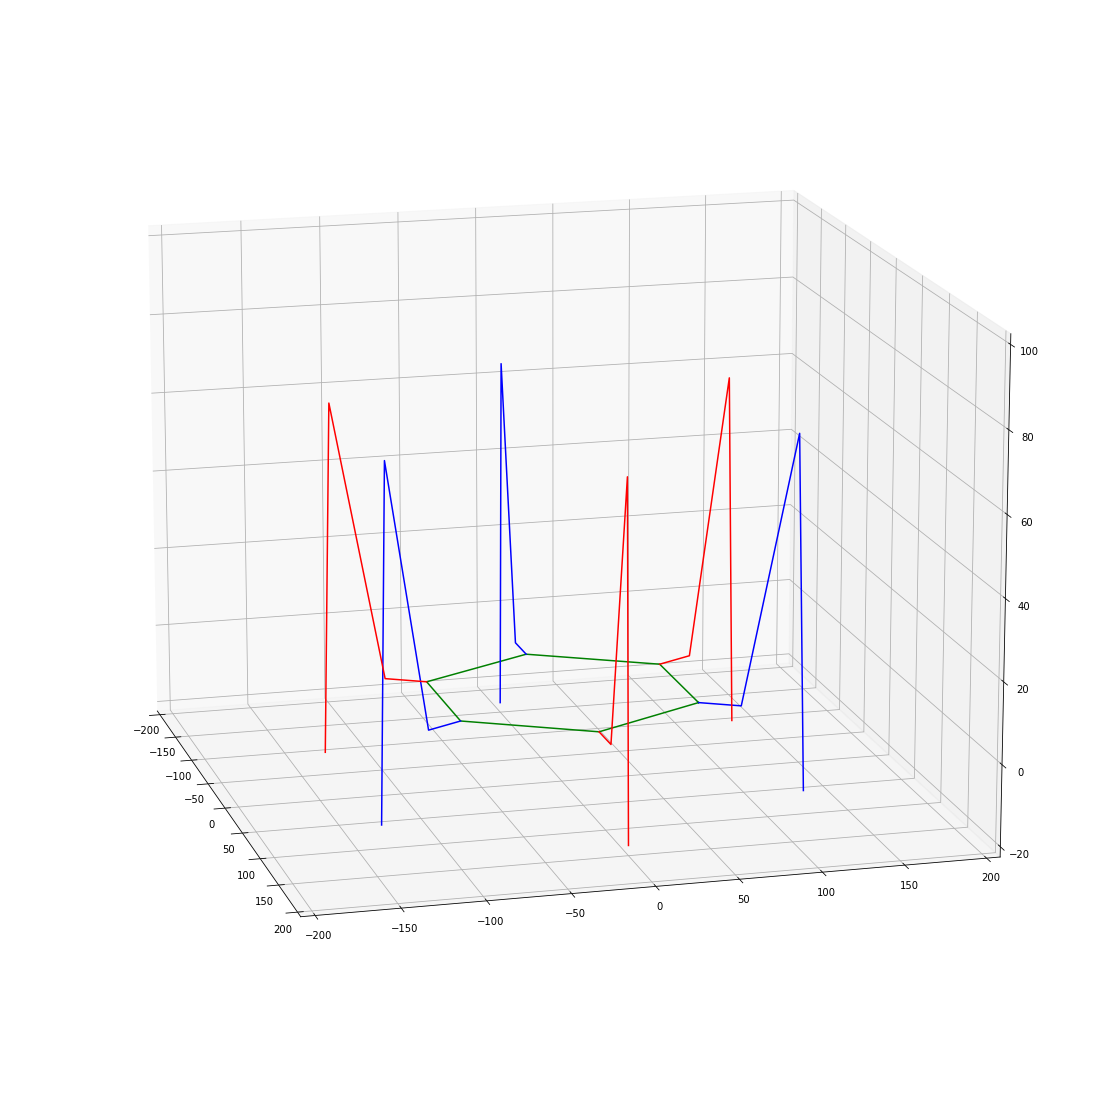

In [19]:
%matplotlib inline
plt.close()
fig = plt.figure(figsize=[15, 15])
showModel(body_model, leg_model, fig = fig)

In [20]:
%matplotlib qt
plt.close()
fig = plt.figure(figsize=[15, 15])

In [21]:
walk(body_model, leg_model, fig = fig, distance = 70, angle = 90)